<a href="https://colab.research.google.com/github/DrKenReid/Debt-Payoff-Simulator/blob/main/Debt_Payoff_Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Debt Repayment Simulator

This notebook demonstrates a Debt Repayment Simulator that compares different debt repayment strategies. It uses Google Sheets to store and manage the data, making it easy for users to input their own financial information.

## Features:
- Automatically creates a Google Drive folder and spreadsheet for data storage
- Populates the spreadsheet with example data
- Compares Avalanche and Snowball debt repayment methods
- Visualizes debt repayment progress over time

## How to use:
1. Run the setup cell below to create the necessary Google Drive folder and spreadsheet
2. Update the spreadsheet with your own financial data (or use the provided example data)
3. Run the subsequent cells to simulate and visualize different debt repayment strategies

Note: This script requires authentication with Google. Make sure you have the necessary permissions and APIs enabled in your Google Cloud Project.

Let's get started by setting up our environment and creating our data storage!

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
from google.colab import auth
from google.auth import default
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

class DebtSimulator:
    """
    A class to simulate and compare debt repayment strategies.

    This simulator uses Google Sheets for data storage and retrieval,
    allowing for easy data management and sharing. It implements both
    the Avalanche and Snowball debt repayment methods, providing
    visualizations and comparisons between the two strategies.
    """

    def __init__(self):
        """
        Initialize the DebtSimulator with necessary Google Services
        and load data from Google Sheets.
        """
        self._setup_environment()
        self._create_or_get_folder()
        self._create_or_get_spreadsheet()
        self._verify_and_populate_data()
        self._load_data()
        self.start_date = datetime.now()

    def _setup_environment(self):
        """Set up the Google services and authentication."""
        sns.set_style("whitegrid")
        auth.authenticate_user()
        creds, _ = default()
        self.drive_service = build('drive', 'v3', credentials=creds)
        self.sheets_service = build('sheets', 'v4', credentials=creds)

    def _create_or_get_folder(self):
        """Create or retrieve the Google Drive folder for data storage."""
        folder_name = "Debt Repayment Simulator"
        query = f"name='{folder_name}' and mimeType='application/vnd.google-apps.folder' and trashed=false"
        results = self.drive_service.files().list(q=query, spaces='drive').execute()
        items = results.get('files', [])

        if not items:
            folder_metadata = {'name': folder_name, 'mimeType': 'application/vnd.google-apps.folder'}
            folder = self.drive_service.files().create(body=folder_metadata, fields='id').execute()
            self.folder_id = folder.get('id')
            print(f"Created folder: {folder_name}")
        else:
            self.folder_id = items[0]['id']
            print(f"Found existing folder: {folder_name}")

    def _create_or_get_spreadsheet(self):
        """Create or retrieve the Google Sheet for data storage."""
        spreadsheet_name = "Debt Repayment Data"
        query = f"name='{spreadsheet_name}' and '{self.folder_id}' in parents and trashed=false"
        results = self.drive_service.files().list(q=query, spaces='drive').execute()
        items = results.get('files', [])

        if not items:
            spreadsheet = {
                'properties': {'title': spreadsheet_name},
                'sheets': [{'properties': {'title': sheet}} for sheet in ['sample-debt-outgoings', 'sample-non-debt-outgoings', 'sample-income']]
            }
            spreadsheet = self.sheets_service.spreadsheets().create(body=spreadsheet).execute()
            self.spreadsheet_id = spreadsheet['spreadsheetId']

            # Move the spreadsheet to the correct folder
            file = self.drive_service.files().get(fileId=self.spreadsheet_id, fields='parents').execute()
            previous_parents = ",".join(file.get('parents'))
            self.drive_service.files().update(fileId=self.spreadsheet_id, addParents=self.folder_id,
                                              removeParents=previous_parents, fields='id, parents').execute()
            print(f"Created spreadsheet: {spreadsheet_name}")
        else:
            self.spreadsheet_id = items[0]['id']
            print(f"Found existing spreadsheet: {spreadsheet_name}")

    def _verify_and_populate_data(self):
        """Verify the existence of required sheets and populate with example data if necessary."""
        required_sheets = ['sample-debt-outgoings', 'sample-non-debt-outgoings', 'sample-income']
        existing_sheets = self._get_existing_sheets()

        for sheet in required_sheets:
            if sheet not in existing_sheets:
                print(f"Sheet '{sheet}' not found. Creating and populating with example data.")
                self._add_sheet(sheet)
                self._populate_example_data(sheet)
            else:
                range_name = f"{sheet}!A1:Z"
                result = self.sheets_service.spreadsheets().values().get(spreadsheetId=self.spreadsheet_id, range=range_name).execute()
                values = result.get('values', [])

                if len(values) <= 1:
                    print(f"Sheet '{sheet}' is empty. Populating with example data.")
                    self._populate_example_data(sheet)
                else:
                    print(f"Sheet '{sheet}' already contains data. Skipping population.")

    def _get_existing_sheets(self):
        """Retrieve a list of existing sheets in the spreadsheet."""
        sheet_metadata = self.sheets_service.spreadsheets().get(spreadsheetId=self.spreadsheet_id).execute()
        return [sheet['properties']['title'] for sheet in sheet_metadata.get('sheets', '')]

    def _add_sheet(self, sheet_name):
        """Add a new sheet to the spreadsheet."""
        request = {'addSheet': {'properties': {'title': sheet_name}}}
        self.sheets_service.spreadsheets().batchUpdate(spreadsheetId=self.spreadsheet_id, body={'requests': [request]}).execute()

    def _populate_example_data(self, sheet_name):
        """Populate a sheet with example data."""
        example_data = {
            'sample-debt-outgoings': [
                ['Company', 'Minimum Payment', 'Total Owed', 'Current APR', 'Expires', 'New APR on Expiry', 'USD', 'GBP'],
                ['Credit Card A', 50, 5000, 18.99, 'NA', 18.99, True, False],
                ['Credit Card B', 75, 7500, 15.99, '12/31/2024', 21.99, True, False],
                ['Personal Loan', 200, 10000, 8.5, 'NA', 8.5, True, False],
                ['Store Card', 25, 1500, 24.99, 'NA', 24.99, True, False]
            ],
            'sample-non-debt-outgoings': [
                ['Expense', 'Total Owed'],
                ['Rent', 1200],
                ['Utilities', 200],
                ['Groceries', 400],
                ['Transportation', 150],
                ['Insurance', 100]
            ],
            'sample-income': [
                ['Source', 'Amount'],
                ['Primary Job', 3500],
                ['Side Hustle', 500]
            ]
        }

        body = {'values': example_data[sheet_name]}
        self.sheets_service.spreadsheets().values().update(
            spreadsheetId=self.spreadsheet_id, range=f"{sheet_name}!A1",
            valueInputOption='USER_ENTERED', body=body).execute()

        self._format_header_row(sheet_name)
        print(f"Populated example data in sheet: {sheet_name}")

    def _format_header_row(self, sheet_name):
        """Format the header row of a sheet to be bold and centered."""
        sheet_id = self._get_sheet_id(sheet_name)
        requests = [{
            'repeatCell': {
                'range': {'sheetId': sheet_id, 'startRowIndex': 0, 'endRowIndex': 1},
                'cell': {'userEnteredFormat': {'textFormat': {'bold': True}, 'horizontalAlignment': 'CENTER'}},
                'fields': 'userEnteredFormat(textFormat,horizontalAlignment)'
            }
        }]
        self.sheets_service.spreadsheets().batchUpdate(spreadsheetId=self.spreadsheet_id, body={'requests': requests}).execute()

    def _get_sheet_id(self, sheet_name):
        """Get the ID of a sheet by its name."""
        sheet_metadata = self.sheets_service.spreadsheets().get(spreadsheetId=self.spreadsheet_id).execute()
        for sheet in sheet_metadata.get('sheets', ''):
            if sheet['properties']['title'] == sheet_name:
                return sheet['properties']['sheetId']
        raise ValueError(f"Sheet '{sheet_name}' not found in the spreadsheet.")

    def _load_data(self):
        """Load data from Google Sheets into pandas DataFrames."""
        datasets = {
            'debt_outgoings': 'sample-debt-outgoings',
            'non_debt_outgoings': 'sample-non-debt-outgoings',
            'income': 'sample-income'
        }

        for attr, sheet_name in datasets.items():
            try:
                df = self._read_sheet(sheet_name)
                setattr(self, attr, df)
                numeric_columns = {
                    'debt_outgoings': ['Minimum Payment', 'Total Owed', 'Current APR', 'New APR on Expiry'],
                    'non_debt_outgoings': ['Total Owed'],
                    'income': ['Amount']
                }.get(attr, [])

                self._convert_numeric_columns(df, numeric_columns)

            except Exception as e:
                print(f"Error loading data from sheet '{sheet_name}': {str(e)}")

    def _convert_numeric_columns(self, df, columns):
        """Convert specified columns to numeric type."""
        for col in columns:
            if col in df.columns:
                try:
                    if col == 'Total Owed':
                        df[col] = df[col].astype(float)
                    else:
                        df[col] = pd.to_numeric(df[col], errors='coerce')
                except Exception as e:
                    print(f"Error converting column '{col}' to numeric: {str(e)}")
            else:
                print(f"Warning: Column '{col}' not found in the dataframe. Skipping conversion.")
        df.fillna(0, inplace=True)

    def _read_sheet(self, range_name):
        """Read a sheet from Google Sheets into a pandas DataFrame."""
        try:
            result = self.sheets_service.spreadsheets().values().get(spreadsheetId=self.spreadsheet_id, range=range_name).execute()
            values = result.get('values', [])
            if not values:
                raise ValueError(f"No data found in sheet '{range_name}'")
            df = pd.DataFrame(values[1:], columns=values[0])
            if df.empty:
                raise ValueError(f"No data found in sheet '{range_name}' after header row")
            return df
        except HttpError as e:
            if e.resp.status == 404:
                raise ValueError(f"Sheet '{range_name}' not found in the spreadsheet")
            else:
                raise

    def run_simulation(self, cc_df, income_df, non_debt_df, method, max_months=1000):
        """
        Run a debt repayment simulation using either the Avalanche or Snowball method.

        Args:
            cc_df (DataFrame): Credit card debt information.
            income_df (DataFrame): Income information.
            non_debt_df (DataFrame): Non-debt expenses information.
            method (str): Either 'avalanche' or 'snowball'.
            max_months (int): Maximum number of months to simulate.

        Returns:
            tuple: A schedule of debt repayment and detailed payment information.
        """
        schedule = []
        payment_details = []
        total_interest = total_principal = 0
        previous_debt = cc_df['Total Owed'].sum()

        for month in range(1, max_months + 1):
            current_date = self.start_date + timedelta(days=30*month)
            cc_df = self._apply_interest(cc_df, current_date)
            total_interest += cc_df['Interest'].sum()
            available_funds = self._calculate_available_funds(income_df, non_debt_df)

            cc_df, remaining_funds = self._distribute_payments(cc_df, available_funds, method)

            total_principal += (available_funds - remaining_funds)
            current_debt = cc_df['Total Owed'].sum()

            schedule.append((month, current_debt, total_interest, total_principal))
            payment_details.extend([{
                'Month': month, 'Company': row['Company'], 'Payment': row['Payment'],
                'Extra Payment': row['Extra Payment'], 'Remaining Debt': row['Total Owed']
            } for _, row in cc_df.iterrows()])

            if current_debt <= 0 or (current_debt > previous_debt and month > 1):
                break
            previous_debt = current_debt

        return schedule, pd.DataFrame(payment_details)

    def _apply_interest(self, cc_df, current_date):
        """Apply interest to credit card balances."""
        cc_df['Total Owed'] = cc_df['Total Owed'].astype(float)  # Ensure 'Total Owed' is float
        for idx, row in cc_df.iterrows():
            apr = row['Current APR']
            if pd.notna(row['Expires']) and row['Expires'] != 'NA':
                try:
                    expiry_date = datetime.strptime(row['Expires'], '%m/%d/%Y')
                    if current_date >= expiry_date:
                        apr = row['New APR on Expiry']
                except ValueError:
                    pass  # If date parsing fails, keep the current APR

            monthly_rate = apr / 1200
            interest = row['Total Owed'] * monthly_rate
            cc_df.at[idx, 'Interest'] = interest
            cc_df.at[idx, 'Total Owed'] += interest
        return cc_df

    @staticmethod
    def _calculate_available_funds(income_df, non_debt_df):
        """Calculate available funds for debt repayment."""
        return max(income_df['Amount'].sum() - non_debt_df['Total Owed'].sum(), 0)

    @staticmethod
    def _distribute_payments(cc_df, available_funds, method):
        """Distribute payments according to the chosen method (avalanche or snowball)."""
        cc_df = cc_df.sort_values(['Current APR', 'Total Owed'], ascending=[False, True] if method == 'avalanche' else [True, True])
        cc_df['Payment'] = cc_df['Extra Payment'] = 0.0
        cc_df['Total Owed'] = cc_df['Total Owed'].astype(float)  # Ensure 'Total Owed' is float
        cc_df['Minimum Payment'] = cc_df['Minimum Payment'].astype(float)  # Ensure 'Minimum Payment' is float

        for idx, row in cc_df.iterrows():
            payment = min(row['Minimum Payment'], row['Total Owed'], available_funds)
            cc_df.at[idx, 'Payment'] = payment
            available_funds -= payment

        if available_funds > 0:
            idx = cc_df.index[0]
            extra = min(available_funds, cc_df.at[idx, 'Total Owed'] - cc_df.at[idx, 'Payment'])
            cc_df.at[idx, 'Payment'] += extra
            cc_df.at[idx, 'Extra Payment'] = extra
            available_funds -= extra

        cc_df['Total Owed'] -= cc_df['Payment']
        return cc_df[cc_df['Total Owed'] > 0.01], available_funds

    def compare_methods(self, avalanche_summary, snowball_summary):
        print("\nMethod Comparison:")
        for method, summary in [("Avalanche", avalanche_summary), ("Snowball", snowball_summary)]:
            print(f"{method} Method:")
            print(f"  Total Months: {summary['total_months']}")
            print(f"  Total Interest Paid: ${summary['total_interest_paid']:.2f}")
            print(f"  Total Amount Paid: ${summary['total_amount_paid']:.2f}")

        interest_diff = snowball_summary['total_interest_paid'] - avalanche_summary['total_interest_paid']
        time_diff = snowball_summary['total_months'] - avalanche_summary['total_months']
        interest_percentage = (interest_diff / snowball_summary['total_interest_paid']) * 100 if snowball_summary['total_interest_paid'] > 0 else 0

        print(f"\nInterest saved with Avalanche: ${interest_diff:.2f} ({interest_percentage:.2f}%)")
        print(f"Time difference: {abs(time_diff)} months {'faster' if time_diff > 0 else 'slower'} with Avalanche")

        if interest_diff > 0:
            print("\nRecommendation: Use the Avalanche method to save on interest.")
        elif interest_diff < 0:
            print("\nRecommendation: Use the Snowball method to save on interest.")
        else:
            print("\nRecommendation: Both methods perform equally. Choose based on personal preference.")

    def plot_results(self, avalanche_schedule, snowball_schedule, avalanche_payments, snowball_payments, title):
        self.plot_total_debt(avalanche_schedule, snowball_schedule, title)
        self.plot_debt_per_card(avalanche_payments, snowball_payments, title)
        self.plot_interest_over_time(avalanche_schedule, snowball_schedule, title)

    @staticmethod
    def plot_total_debt(avalanche_schedule, snowball_schedule, title):
        plt.figure(figsize=(12, 6))
        for schedule, label, style in [
            (avalanche_schedule, 'Avalanche', '-'),
            (snowball_schedule, 'Snowball', '--')
        ]:
            plt.plot(*zip(*[(m, d) for m, d, _, _ in schedule]), label=label, linestyle=style)
        plt.title(f'{title} - Total Debt Remaining Over Time')
        plt.xlabel('Month')
        plt.ylabel('Total Debt Remaining')
        plt.legend()
        plt.grid(True)
        plt.show()

    @staticmethod
    def plot_debt_per_card(avalanche_payments, snowball_payments, title):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))
        for ax, data, method in [
            (ax1, avalanche_payments, 'Avalanche'),
            (ax2, snowball_payments, 'Snowball')
        ]:
            plot_data = data.pivot(index='Month', columns='Company', values='Remaining Debt').fillna(0)
            plot_data.plot.area(ax=ax, stacked=True)
            ax.set_title(f'Debt Per Credit Card Over Time - {method} Method')
            ax.set_xlabel('Month')
            ax.set_ylabel('Debt Amount')
            ax.legend(title='Credit Cards', bbox_to_anchor=(1.05, 1), loc='upper left')
            ax.set_ylim(bottom=0)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_interest_over_time(avalanche_schedule, snowball_schedule, title):
        plt.figure(figsize=(12, 6))
        for schedule, label, style in [
            (avalanche_schedule, 'Avalanche', '-'),
            (snowball_schedule, 'Snowball', '--')
        ]:
            plt.plot(*zip(*[(m, i) for m, _, i, _ in schedule]), label=label, linestyle=style)
        plt.title(f'{title} - Cumulative Interest Paid Over Time')
        plt.xlabel('Month')
        plt.ylabel('Cumulative Interest Paid')
        plt.legend()
        plt.grid(True)
        plt.show()

    def output_payment_plans(self, name, avalanche_payments, snowball_payments):
        """Output payment plans to Google Sheets."""
        avalanche_data = self.prepare_payment_plan_data(avalanche_payments, 'Avalanche')
        snowball_data = self.prepare_payment_plan_data(snowball_payments, 'Snowball')

        self.create_or_update_sheet(f"{name} Avalanche Plan", avalanche_data)
        self.create_or_update_sheet(f"{name} Snowball Plan", snowball_data)

    def prepare_payment_plan_data(self, payments_df, method):
        """Prepare payment plan data for Google Sheets with a month/company per row."""
        data = [['Month', 'Company', 'Payment', 'Extra Payment', 'Remaining Debt']]

        for month in payments_df['Month'].unique():
            month_data = payments_df[payments_df['Month'] == month]
            for _, row in month_data.iterrows():
                data.append([
                    int(month),  # Convert numpy.int64 to standard Python int
                    str(row['Company']),
                    f"${float(row['Payment']):.2f}",
                    f"${float(row['Extra Payment']):.2f}",
                    f"${float(row['Remaining Debt']):.2f}"
                ])

        return data

    def create_or_update_sheet(self, sheet_name, data):
        """Create a new sheet or update an existing one with the given data and formatting."""
        try:
            # Check if the sheet already exists
            sheet_metadata = self.sheets_service.spreadsheets().get(spreadsheetId=self.spreadsheet_id).execute()
            sheet_id = None
            for sheet in sheet_metadata['sheets']:
                if sheet['properties']['title'] == sheet_name:
                    sheet_id = sheet['properties']['sheetId']
                    break

            if sheet_id is not None:
                # Clear existing content
                self.sheets_service.spreadsheets().values().clear(
                    spreadsheetId=self.spreadsheet_id,
                    range=sheet_name
                ).execute()
            else:
                # Create new sheet
                request = {
                    'addSheet': {
                        'properties': {
                            'title': sheet_name
                        }
                    }
                }
                result = self.sheets_service.spreadsheets().batchUpdate(
                    spreadsheetId=self.spreadsheet_id,
                    body={'requests': [request]}
                ).execute()
                sheet_id = result['replies'][0]['addSheet']['properties']['sheetId']

            # Update sheet with new data
            range_name = f"{sheet_name}!A1"
            self.sheets_service.spreadsheets().values().update(
                spreadsheetId=self.spreadsheet_id,
                range=range_name,
                valueInputOption="USER_ENTERED",
                body={"values": data}
            ).execute()

            # Apply formatting
            requests = [
                {
                    'repeatCell': {
                        'range': {
                            'sheetId': sheet_id,
                            'startRowIndex': 0,
                            'endRowIndex': 1
                        },
                        'cell': {
                            'userEnteredFormat': {
                                'textFormat': {'bold': True}
                            }
                        },
                        'fields': 'userEnteredFormat.textFormat.bold'
                    }
                },
                {
                    'updateSheetProperties': {
                        'properties': {
                            'sheetId': sheet_id,
                            'gridProperties': {
                                'frozenRowCount': 1
                            }
                        },
                        'fields': 'gridProperties.frozenRowCount'
                    }
                },
                {
                    'autoResizeDimensions': {
                        'dimensions': {
                            'sheetId': sheet_id,
                            'dimension': 'COLUMNS',
                            'startIndex': 0,
                            'endIndex': 5  # Assuming 5 columns
                        }
                    }
                }
            ]

            self.sheets_service.spreadsheets().batchUpdate(
                spreadsheetId=self.spreadsheet_id,
                body={'requests': requests}
            ).execute()

            print(f"Updated sheet: {sheet_name}")

        except Exception as e:
            print(f"An error occurred while updating sheet {sheet_name}: {str(e)}")

    def generate_summary(self, schedule, method, initial_debt):
        final_month = schedule[-1]
        return {
            'method': method,
            'initial_debt': initial_debt,
            'total_months': len(schedule),
            'total_interest_paid': final_month[2],
            'total_amount_paid': final_month[2] + final_month[3]
        }

# Create the simulator instance
try:
    simulator = DebtSimulator()
    print(f"Spreadsheet ID: {simulator.spreadsheet_id}")
    print("You can now access this spreadsheet in your Google Drive under the 'Debt Repayment Simulator' folder.")
except Exception as e:
    print(f"An error occurred while setting up the Debt Simulator: {str(e)}")

Found existing folder: Debt Repayment Simulator
Found existing spreadsheet: Debt Repayment Data
Sheet 'sample-debt-outgoings' already contains data. Skipping population.
Sheet 'sample-non-debt-outgoings' already contains data. Skipping population.
Sheet 'sample-income' already contains data. Skipping population.
Spreadsheet ID: 1ZB56IkxAV7T6vU6UKDg7le-xEX-nGe7VQFRJ1IYiPa0
You can now access this spreadsheet in your Google Drive under the 'Debt Repayment Simulator' folder.


Running Debt Repayment Simulations...

Method Comparison:
Avalanche Method:
  Total Months: 15
  Total Interest Paid: $2057.27
  Total Amount Paid: $28114.53
Snowball Method:
  Total Months: 15
  Total Interest Paid: $2852.47
  Total Amount Paid: $29704.94

Interest saved with Avalanche: $795.20 (27.88%)
Time difference: 0 months slower with Avalanche

Recommendation: Use the Avalanche method to save on interest.


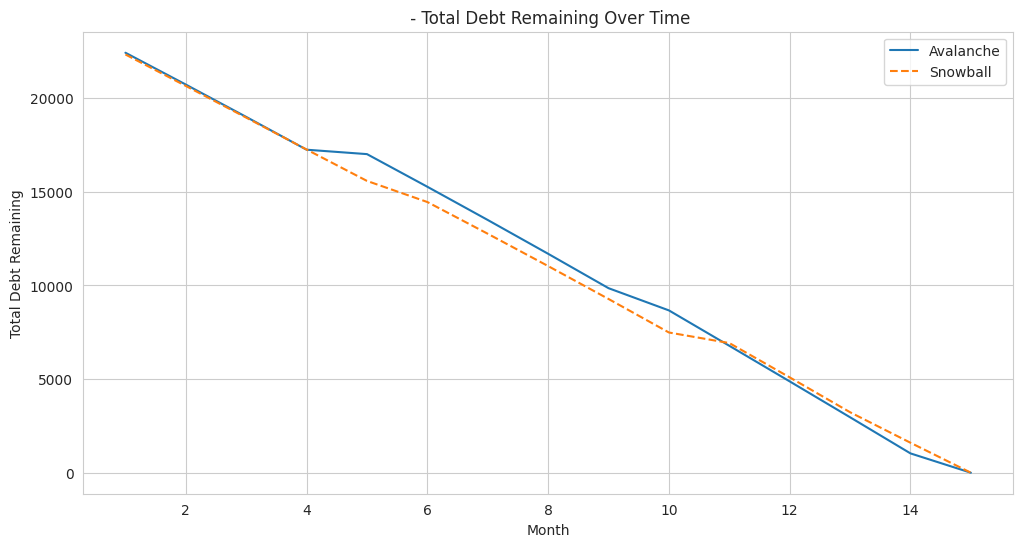

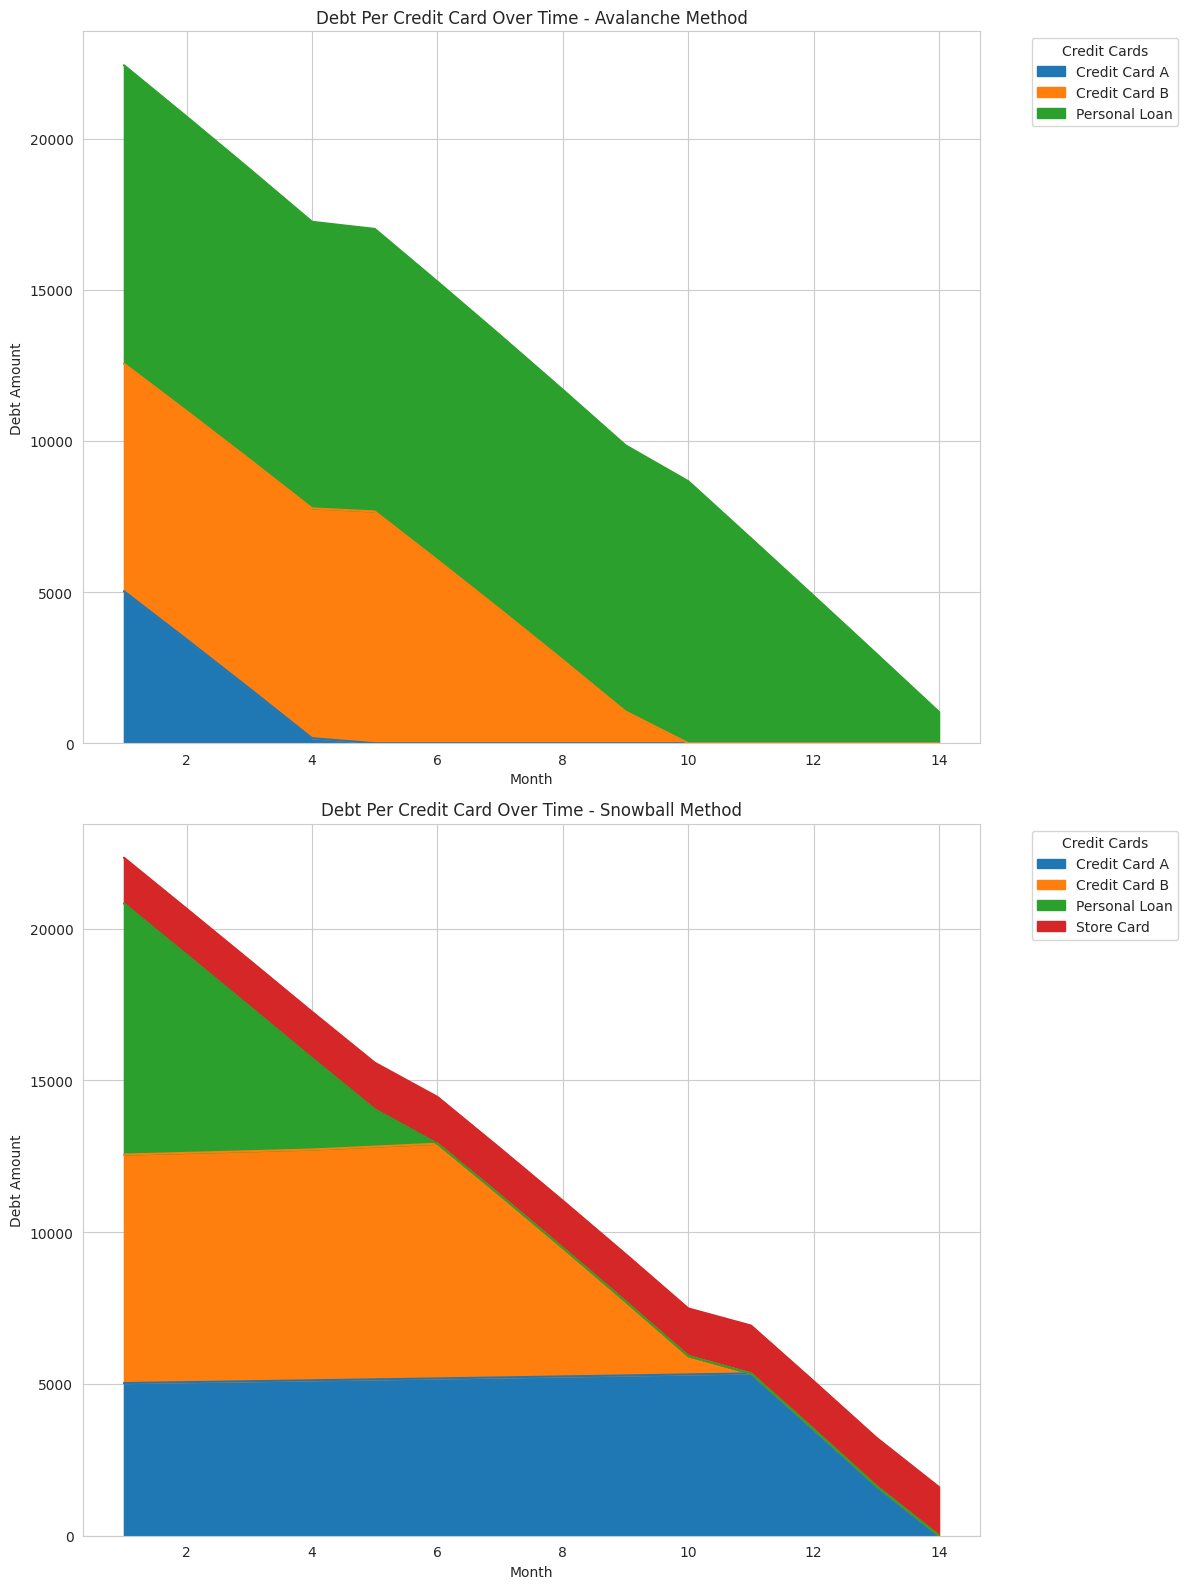

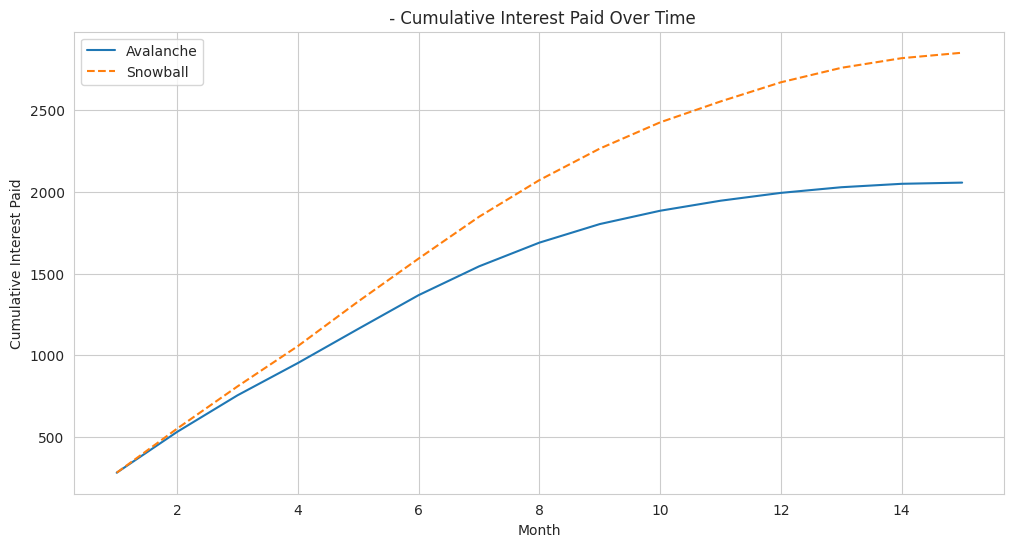

Updated sheet: Sample Avalanche Plan
Updated sheet: Sample Snowball Plan

Payment plans have been output to Google Sheets. Please check your Google Drive for the updated spreadsheet.


In [10]:
# Define simulation methods
def run_avalanche_method(simulator, cc_df, income_df, non_debt_df):
    return simulator.run_simulation(cc_df.copy(), income_df, non_debt_df, 'avalanche')

def run_snowball_method(simulator, cc_df, income_df, non_debt_df):
    return simulator.run_simulation(cc_df.copy(), income_df, non_debt_df, 'snowball')

# Run simulations
print("Running Debt Repayment Simulations...")

initial_debt = simulator.debt_outgoings['Total Owed'].sum()

avalanche_schedule, avalanche_payments = run_avalanche_method(
    simulator, simulator.debt_outgoings, simulator.income, simulator.non_debt_outgoings
)
snowball_schedule, snowball_payments = run_snowball_method(
    simulator, simulator.debt_outgoings, simulator.income, simulator.non_debt_outgoings
)

# Generate summaries
avalanche_summary = simulator.generate_summary(avalanche_schedule, 'avalanche', initial_debt)
snowball_summary = simulator.generate_summary(snowball_schedule, 'snowball', initial_debt)

# Compare methods
simulator.compare_methods(avalanche_summary, snowball_summary)

# Plot results
simulator.plot_results(avalanche_schedule, snowball_schedule, avalanche_payments, snowball_payments, "")

# Output payment plans to Google Sheets
simulator.output_payment_plans("Sample", avalanche_payments, snowball_payments)

print("\nPayment plans have been output to Google Sheets. Please check your Google Drive for the updated spreadsheet.")

## Understanding the Visualizations

1. **Total Debt Remaining Over Time**: This graph shows how the total debt decreases over time for both methods. The steeper the line, the faster the debt is being paid off.

2. **Debt Per Credit Card Over Time**: These stacked area plots show how each individual debt changes over time. You can see which debts are paid off first in each method.

3. **Cumulative Interest Paid Over Time**: This graph shows how much interest you've paid in total over time. A lower line means you're paying less in interest.
